In [2]:
import config as cfg
from models.efficientdeeplab import EfficientDeeplab, Backbones
from models.sunet import SUnet
from models.unet import Unet
import numpy as np


backbone = Backbones.B2
fold_n = 0

model = EfficientDeeplab(
    input_shape = cfg.IMAGE_SHAPE + (cfg.N_CHANNELS,),
    backbone = backbone,
    n_classes = cfg.N_CLASSES,
    activation = 'sigmoid'
)

# model = SUnet(
#     input_shape = cfg.IMAGE_SHAPE + (cfg.N_CHANNELS,),
#     n_classes = cfg.N_CLASSES
# )

output_folder = f"output/{model.name}_{fold_n}"
checkpoint_path = f"{output_folder}/checkpoint"

model.load_weights(f"{checkpoint_path}/{model.name}").expect_partial()

# Model Predictions

In [3]:
import utils
import numpy as np
import tensorflow as tf
from generators import PatientWiseGenerator
from postprocessing import biggest_3D_object
import config as cfg

metrics = {
    "dice":[],
    "precision":[],
    "recall":[],
    "iou_score":[],
}

metrics_post_processed = {
    "dice":[],
    "precision":[],
    "recall":[],
    "iou_score":[],
}


_, _, test_patients = list(utils.kfold(cfg.DATASET_PATH))[0]

# ===== TEST ===== #

for patient in test_patients:
    generator = PatientWiseGenerator(patient, cfg.N_CLASSES)
    patient_dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=
        (
            tf.TensorSpec(shape=cfg.IMAGE_SHAPE + (cfg.N_CHANNELS,)),
            tf.TensorSpec(shape=cfg.IMAGE_SHAPE + (cfg.N_CLASSES,))
        )
    )
    
    volume_true = []
    for (x, y) in patient_dataset:
        volume_true.append(y)
    volume_true = np.squeeze(np.array(volume_true))

    volume_pred = model.predict(patient_dataset.batch(5), verbose=0)
    volume_pred = np.round(volume_pred)
    volume_pred = np.squeeze(volume_pred)

    metrics["dice"].append(cfg.f_score(volume_true, volume_pred))
    metrics["precision"].append(cfg.precision_score(volume_true, volume_pred))
    metrics["recall"].append(cfg.recall_score(volume_true, volume_pred))
    metrics["iou_score"].append(cfg.iou_score(volume_true, volume_pred))

    # post process each channel
    volume_post_processed = biggest_3D_object(volume_pred)

    metrics_post_processed["dice"].append(cfg.f_score(volume_true, volume_pred))
    metrics_post_processed["precision"].append(cfg.precision_score(volume_true, volume_pred))
    metrics_post_processed["recall"].append(cfg.recall_score(volume_true, volume_pred))
    metrics_post_processed["iou_score"].append(cfg.iou_score(volume_true, volume_pred))
    
    break

2024-05-21 08:31:01.026611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204


In [29]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure, morphology
import matplotlib.pyplot as plt
def plot_3d(image):
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    colors = [
        (102/255, 119/255, 97/255), # esofago
        (145/255, 166/255, 255/255), # coração
        (23/255, 24/255, 59/255), #  traqueia
        # (247/255, 169/255, 168/255) # aorta
        (176/255, 65/255, 62/255) # aorta
        
    ]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    p = np.transpose(image, (2, 1, 0))
    
    verts, faces, normal, values = measure.marching_cubes(p)

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.7)
    face_color = colors[2]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    
    ax.xaxis._axinfo["grid"].update({"linewidth":2, "linestyle":"-.", "color":"white"})
    ax.yaxis._axinfo["grid"].update({"linewidth":2, "linestyle":"-.", "color":"white"})
    ax.zaxis._axinfo["grid"].update({"linewidth":2, "linestyle":"-.", "color":"white"})

    ax.xaxis.set_pane_color("whitesmoke")

    
    ax.legend(['Traqueia'])
    plt.title("Predição Pós Processamento")

    fig.canvas.draw()
    img_plot = np.array(fig.canvas.renderer.buffer_rgba())
    return img_plot

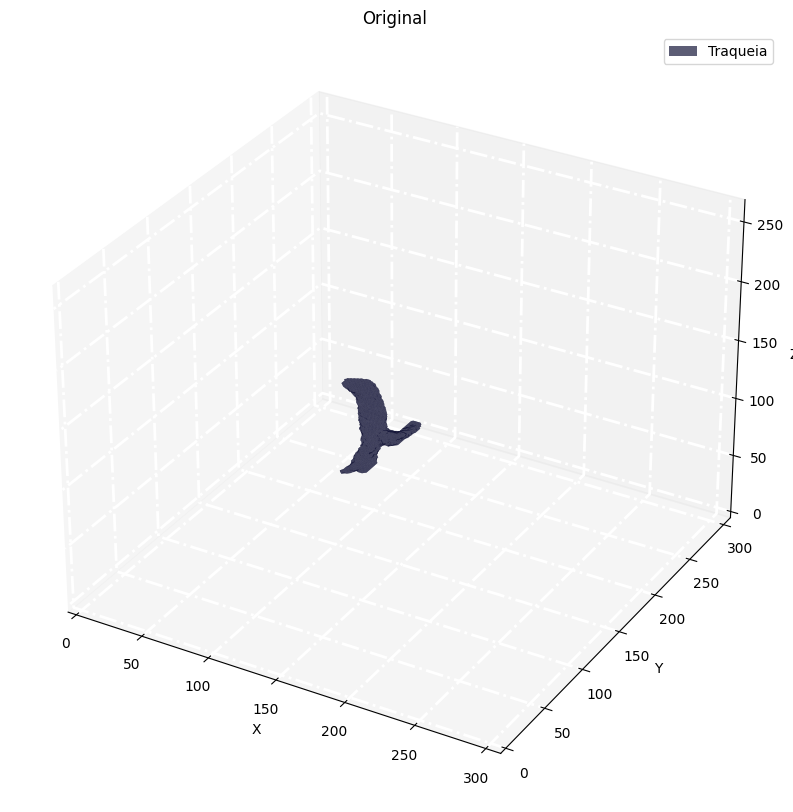

In [23]:
plot_true = plot_3d(volume_true)
plot_true = cv.cvtColor(plot_true, cv.COLOR_RGB2BGR)

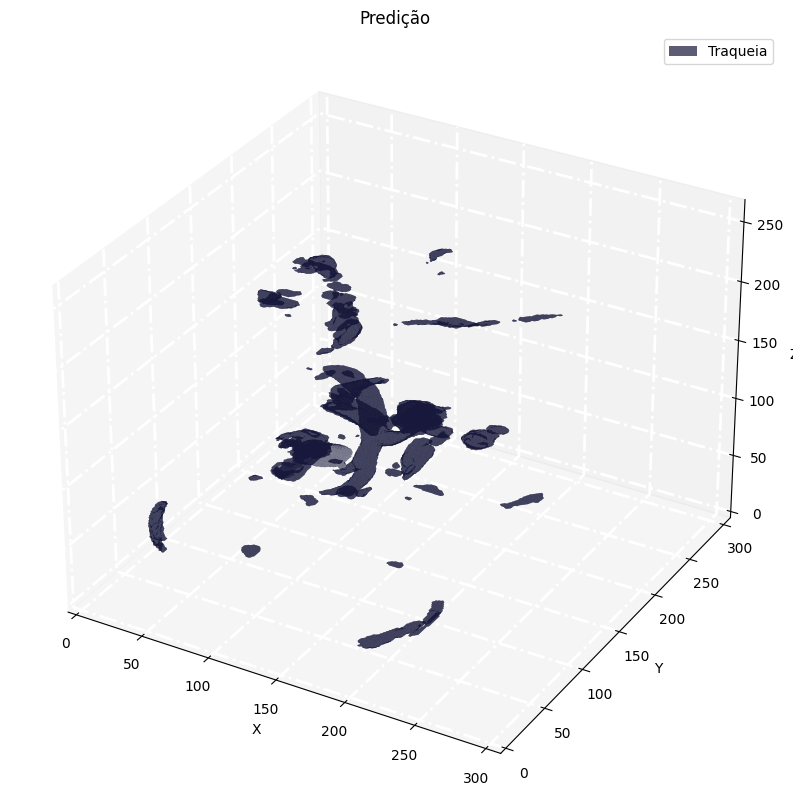

In [25]:
plot_pred = plot_3d(volume_pred)
plot_pred = cv.cvtColor(plot_pred, cv.COLOR_RGB2BGR)

In [26]:
import cv2 as cv

out = cv.hconcat([plot_true, plot_pred])
cv.imwrite("out.png", out)

True

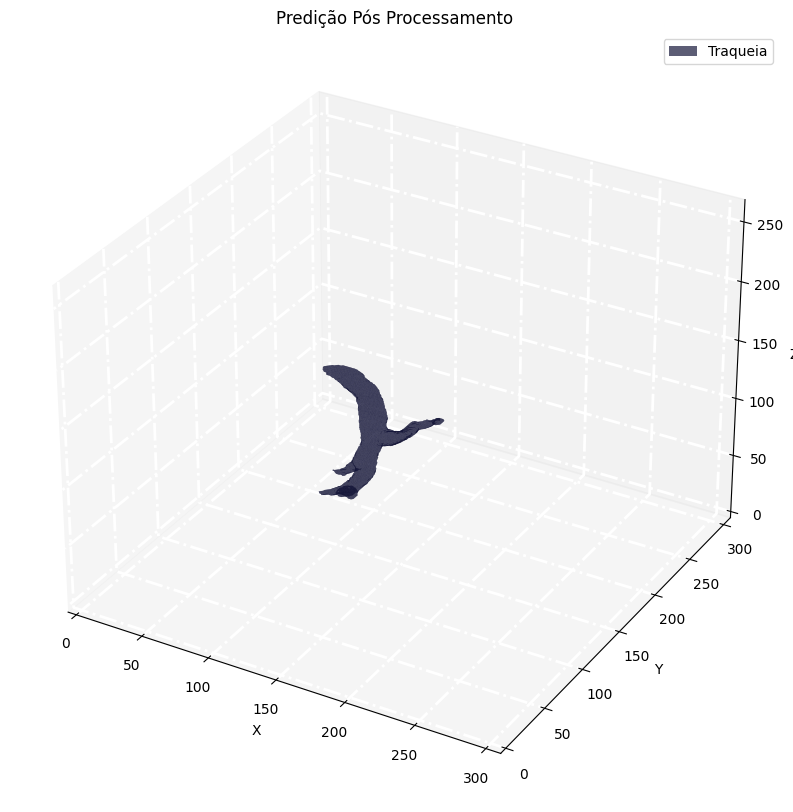

In [30]:
plot_post_processed = plot_3d(volume_post_processed)
plot_post_processed = cv.cvtColor(plot_post_processed, cv.COLOR_RGB2BGR)

In [31]:
import cv2 as cv

out = cv.hconcat([plot_pred, plot_post_processed])
cv.imwrite("out.png", out)

True

# Loss Curve

Text(0.5, 1.0, 'Train/Val Loss x Epochs')

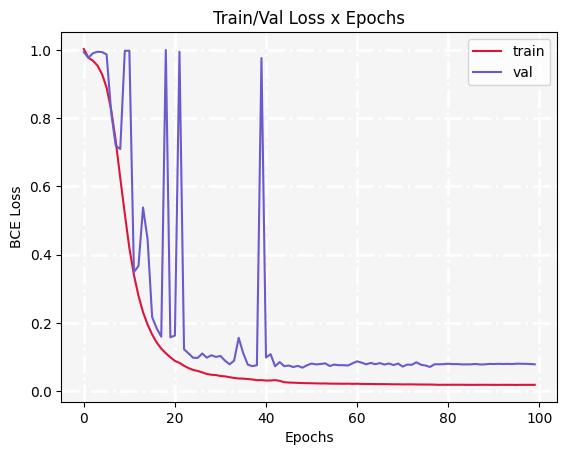

In [8]:
import pickle
import matplotlib.pyplot as plt

# output_folder = f"output/{model.name}_{fold_n}"
# output_folder = 'output/EfficientDeeplabB0_0'

with open(f"{output_folder}/history", "rb") as f:
    h = pickle.load(f)
plt.xlabel("Epochs")
plt.ylabel("BCE Loss")
plt.gca().set_facecolor("whitesmoke")
# plt.gca().set_ylim(0, 1)
plt.grid(color='w', linewidth=2, linestyle='-.')
plt.plot(h['loss'], c='crimson')
plt.plot(h['val_loss'], c='slateblue')
plt.legend(['train', 'val'])

plt.title("Train/Val Loss x Epochs")

# Dice Score Curve

Text(0.5, 1.0, 'Train/Val Dice Score x Epochs')

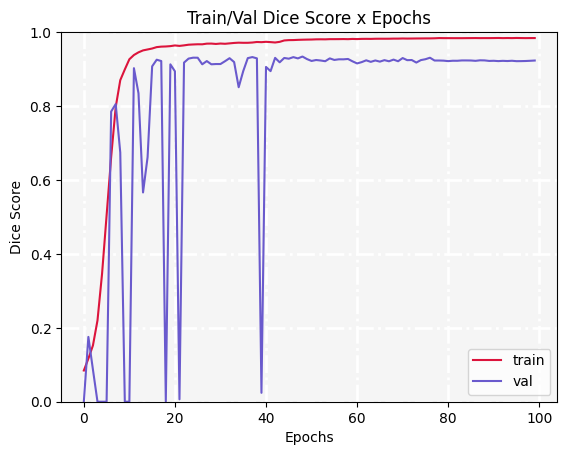

In [9]:
import pickle
import matplotlib.pyplot as plt

with open(f"{output_folder}/history", "rb") as f:
    h = pickle.load(f)
plt.xlabel("Epochs")
plt.ylabel("Dice Score")
plt.gca().set_facecolor("whitesmoke")
plt.gca().set_ylim(0, 1)
plt.grid(color='w', linewidth=2, linestyle='-.')
plt.plot(h['f1-score'], c='crimson')
plt.plot(h['val_f1-score'], c='slateblue')
plt.legend(['train', 'val'])
plt.title("Train/Val Dice Score x Epochs")

# Metrics

## History

In [10]:
import pickle

with open(f"{output_folder}/history", "rb") as f:
    h = pickle.load(f)
# print(h.keys())
print(f"train loss: {np.min(h['loss'])}")
print(f"val loss: {np.min(h['val_loss'])}")
print(f"train f1-score: {np.max(h['f1-score'])}")
print(f"val f1-score: {np.max(h['val_f1-score'])}")

train loss: 0.018375109881162643
val loss: 0.0689680352807045
train f1-score: 0.9841604232788086
val f1-score: 0.9339189529418945


In [23]:
arr = [92.65, 94.17, 91.38]
np.mean(arr), np.std(arr)

(92.73333333333333, 1.1405359364010534)

## Before PostProcessing

In [11]:
import pickle
import tensorflow as tf

with open(f"{output_folder}/test_metrics", "rb") as f:
    metrics = pickle.load(f)

for m in metrics:
    # print(np.mean(metrics[m]))
    print(f"{m}: {tf.reduce_mean(metrics[m])}")

dice: 0.4694477915763855
precision: 0.5149255394935608
recall: 0.9564512968063354
iou_score: 0.4533139765262604


## After PostProcessing

In [12]:
import pickle
# import tensorflow as tf

with open(f"{output_folder}/test_metrics_post_processing", "rb") as f:
    metrics = pickle.load(f)

for m in metrics:
    # print(np.mean(metrics[m]))
    print(f"{m}: {tf.reduce_mean(metrics[m])}")

dice: 0.8398433327674866
precision: 0.5218411684036255
recall: 0.9559845328330994
iou_score: 0.8250595927238464


# Handling Under-Annotation

# Comparing Nº of Parameters

In [32]:
edl = EfficientDeeplab(
    input_shape = cfg.IMAGE_SHAPE + (cfg.N_CHANNELS,),
    backbone = Backbones.B2,
    n_classes = cfg.N_CLASSES,
    activation = 'sigmoid'
)

sunet = SUnet(
    input_shape = cfg.IMAGE_SHAPE + (cfg.N_CHANNELS,),
    n_classes = cfg.N_CLASSES
)

unet = Unet(
    input_shape = cfg.IMAGE_SHAPE + (cfg.N_CHANNELS,),
    n_classes = cfg.N_CLASSES
)

In [33]:
edl.summary()

Model: "EfficientDeeplabB2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 304, 304, 1)]     0         
                                                                 
 channel_expansion (Conv2D)  (None, 304, 304, 3)       6         
                                                                 
 deep_lab_v3plus_2 (DeepLabV  (None, 304, 304, 1)      2284662   
 3plus)                                                          
                                                                 
Total params: 2,284,668
Trainable params: 2,274,275
Non-trainable params: 10,393
_________________________________________________________________


In [15]:
sunet.summary()

Model: "SUnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 304, 304, 1  0           []                               
                                )]                                                                
                                                                                                  
 encoder1_conv1 (Conv2D)        (None, 304, 304, 64  640         ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 encoder1_conv1_relu (Activatio  (None, 304, 304, 64  0          ['encoder1_conv1[0][0]']         
 n)                             )                                                             

In [16]:
unet.summary()

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 304, 304, 1  0           []                               
                                )]                                                                
                                                                                                  
 encoder1_conv1 (Conv2D)        (None, 304, 304, 64  640         ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 encoder1_conv1_relu (Activatio  (None, 304, 304, 64  0          ['encoder1_conv1[0][0]']         
 n)                             )                                                              